In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip Dataset
!rm -rf "/content/mango_leaf_data"
!unzip -o "/content/drive/MyDrive/mango_leaf_data.zip" -d "/content/mango_leaf_data"

Archive:  /content/drive/MyDrive/mango_leaf_data.zip
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/20211008_124312 (Custom).jpg  
  inflating: /content/mango_leaf_data/Anthracnose/202110

In [4]:
# Upgrade pip
!pip install --upgrade pip --quiet

# Install MLflow + pyngrok
!pip install --quiet \
    mlflow==2.14.3 \
    pyngrok==7.4.0 \
    "docker<8" \
    "graphene<4" \
    "querystring-parser<2" \
    "gunicorn<23" \
    "importlib-metadata<8" \
    "packaging<25" \
    "pyarrow>=15.0.0,<19" \
    "pytz<2025" \
    "protobuf>=4.25.3,<6"

In [5]:
import tensorflow as tf
import mlflow

print("TensorFlow:", tf.__version__)
print("MLflow:", mlflow.__version__)

TensorFlow: 2.19.0
MLflow: 2.14.3


In [6]:
# Imports
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, BackupAndRestore, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from mlflow.exceptions import MlflowException
from mlflow.models.signature import infer_signature

In [7]:
# mlflow setup
import mlflow
import mlflow.tensorflow
from pyngrok import ngrok
import subprocess

In [8]:
# Create a MLflow folder inside Google Drive
mlflow_drive_dir = "/content/drive/MyDrive/mlflow_runs"
import os
os.makedirs(mlflow_drive_dir, exist_ok=True)

In [9]:
# Enable TensorFlow autologging
mlflow.tensorflow.autolog(log_models=True, log_datasets=False)

2025/11/15 06:58:06 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [10]:
# Start MLflow UI via ngrok

# Authenticate ngrok in Colab
from pyngrok import ngrok

# Set ngrok authtoken
NGROK_TOKEN = "35TfwvuBdLvaswu4B2KsZpZKX3e_5RKSRH4PuwCYubgdKh9Lt"
ngrok.set_auth_token(NGROK_TOKEN)

In [11]:
# Kill old MLflow if already running
!ps aux | grep "mlflow ui" | grep -v grep | awk '{print $2}' | xargs -r kill -9 || echo "No MLflow instance running"

In [12]:
# Kill old tunnels
ngrok.kill()

In [13]:
# Start MLflow server bound to all interfaces
subprocess.Popen([
    "mlflow", "ui",
    "--backend-store-uri", f"sqlite:///{mlflow_drive_dir}/mlflow.db",
    "--default-artifact-root", mlflow_drive_dir,
    "--host", "0.0.0.0",
    "--port", "5000"
])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

In [14]:
# Wait a few seconds to ensure MLflow starts
time.sleep(5)

In [15]:
# Point notebook to the same backend
mlflow.set_tracking_uri(f"http://127.0.0.1:5000")

In [16]:
# Define experiment name
experiment_name = "MangoLeaf_ResNet50V2"

# Create the experiment if it doesn't exist
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(
        name=experiment_name,
        artifact_location=mlflow_drive_dir  # store artifacts (models, plots) here
    )

# Set the experiment for logging
mlflow.set_experiment(experiment_name)

print(f"MLflow experiment '{experiment_name}' is set!")

MLflow experiment 'MangoLeaf_ResNet50V2' is set!


In [17]:
# Retrieve experiment details
exp = mlflow.get_experiment_by_name(experiment_name)
print("Current Experiment:")
print(f"  ID: {exp.experiment_id}")
print(f"  Name: {exp.name}")
print(f"  Artifact Location: {exp.artifact_location}")

Current Experiment:
  ID: 1
  Name: MangoLeaf_ResNet50V2
  Artifact Location: /content/drive/MyDrive/mlflow_runs


In [18]:
# Open ngrok tunnel to access MLflow UI
mlflow_url = ngrok.connect(5000)
print("MLflow Tracking UI:", mlflow_url)

MLflow Tracking UI: NgrokTunnel: "https://brent-toadless-isagogically.ngrok-free.dev" -> "http://localhost:5000"


In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

def start_mlflow_run_auto(run_prefix="Run", nested=False):
    """
    Start a new MLflow run with an auto-incremented name.
    """
    experiment_name = "MangoLeaf_ResNet50V2"
    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

    # Use MlflowClient to fetch existing runs in the experiment
    client = MlflowClient()
    runs = client.search_runs([experiment.experiment_id])

    run_number = len(runs) + 1
    run_name = f"{run_prefix}_{run_number}"

    return mlflow.start_run(run_name=run_name, experiment_id=experiment.experiment_id, nested=nested)

In [ ]:
folders = sorted(os.listdir('/content/mango_leaf_data'))
print("Folders inside mango_leaf_data:", folders)

Folders inside mango_leaf_data: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, destination_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    splits = ['train', 'val', 'test']
    split_dirs = {split: os.path.join(destination_dir, split) for split in splits}

    # Create split directories
    for dir_path in split_dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    for disease_class in os.listdir(source_dir):
        class_path = os.path.join(source_dir, disease_class)
        if not os.path.isdir(class_path):
            continue

        # Create class folders inside train/val/test
        for dir_path in split_dirs.values():
            os.makedirs(os.path.join(dir_path, disease_class), exist_ok=True)

        images = os.listdir(class_path)
        train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img_list, split in zip([train_imgs, val_imgs, test_imgs], splits):
            for image in img_list:
                src = os.path.join(class_path, image)
                dst = os.path.join(split_dirs[split], disease_class, image)
                shutil.copy(src, dst)


source_dir = '/content/mango_leaf_data'
destination_dir = '/content/mango_data_split'

split_dataset(source_dir, destination_dir)
print("Dataset split completed!")

Dataset split completed!


In [ ]:
split_dataset_path = '/content/mango_data_split/train'  # change path to your mango train folder

class_names = [folder for folder in os.listdir(split_dataset_path)
               if os.path.isdir(os.path.join(split_dataset_path, folder))]

for class_name in class_names:
    class_path = os.path.join(split_dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} images")

Anthracnose: 400 images
Bacterial Canker: 400 images
Die Back: 400 images
Sooty Mould: 400 images
Healthy: 400 images
Powdery Mildew: 400 images
Gall Midge: 400 images
Cutting Weevil: 400 images


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

target_size = (224, 224)
batch_size = 32
num_classes = 8
channels = 3
epochs = 40

def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(p2, p98))
    return image

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    channel_shift_range=30.0,
    shear_range=20.0
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3]
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3]
)

train_generator = train_datagen.flow_from_directory(
    '/content/mango_data_split/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/mango_data_split/val',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/mango_data_split/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights based on the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary format
class_weight_dict = dict(enumerate(class_weights))

# Display the computed class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [ ]:
class GradualUnfreezing(tf.keras.callbacks.Callback):
    def __init__(self, base_model, num_epochs_per_unfreeze=5):
        super().__init__()
        self.base_model = base_model
        self.num_epochs_per_unfreeze = num_epochs_per_unfreeze
        self.unfrozen_layers = 0

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs_per_unfreeze == 0:
            if self.unfrozen_layers < len(self.base_model.layers):
                # Unfreeze 10 more layers every few epochs
                for layer in self.base_model.layers[-(self.unfrozen_layers + 10):]:
                    layer.trainable = True
                self.unfrozen_layers += 10
                print(f"\nUnfreezing layers: {self.unfrozen_layers}")

In [ ]:
# model architecture
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, regularizers, Model, Input

def build_model(num_classes):
    # Initialize ResNet50V2 base
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Input layer
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)

    # Global pooling and dropout
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Residual block 1
    x1 = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.3)(x1)
    x_res = layers.Dense(1024, activation='linear')(x)
    x = layers.Add()([x_res, x1])
    x = layers.Activation('relu')(x)

    # Residual block 2
    x2 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x2 = layers.Dropout(0.3)(x2)
    x_res2 = layers.Dense(512, activation='linear')(x)
    x = layers.Add()([x_res2, x2])
    x = layers.Activation('relu')(x)

    # Residual block 3
    x3 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x3 = layers.Dropout(0.3)(x3)
    x_res3 = layers.Dense(256, activation='linear')(x)
    x = layers.Add()([x_res3, x3])
    x = layers.Activation('relu')(x)

    # Final output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Return fresh model
    return Model(inputs, outputs)

In [ ]:
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(target_size[0], target_size[1], channels)
)

model = build_model(num_classes)

In [ ]:
# Learning Rate Schedule

#initial_learning_rate = 1e-4
initial_learning_rate = 1e-3
warmup_epochs = 5
total_epochs = epochs

def warmup_cosine_decay_schedule(epoch):
    if epoch < warmup_epochs:
        return initial_learning_rate * ((epoch + 1) / warmup_epochs)
    else:
        return initial_learning_rate * (
            0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        )

In [ ]:
import os

# Save checkpoints and backup to Google Drive
checkpoint_dir = "/content/drive/MyDrive/mango_leaf_checkpoints"
backup_dir = "/content/drive/MyDrive/mango_leaf_backup"
tensorboard_log_dir = "/content/drive/MyDrive/mango_leaf_tensorboard_logs"

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(backup_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [ ]:
callbacks = [
    # Stops training early if val_loss doesn't improve
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
        verbose=1
    ),

    # Saves the best model based on validation accuracy
    tf.keras.callbacks.ModelCheckpoint(
        'best_mangomodel_0109.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Custom learning rate schedule (warm-up + cosine decay)
    tf.keras.callbacks.LearningRateScheduler(warmup_cosine_decay_schedule),

    # Custom gradual unfreezing callback to fine-tune layers gradually
    GradualUnfreezing(base_model),

    # Backup the training progress (useful in Colab)
    tf.keras.callbacks.BackupAndRestore(backup_dir='./backup'),

    # TensorBoard log for training monitoring
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ input_layer_10[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1024)      │  2,098,176 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1024)      │  2,098,176 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 1024)      │          0 │ dense_20[0][0],   │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1024)      │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │    524,800 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 512)       │    524,800 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 512)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 512)       │          0 │ dense_22[0][0],   │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 512)       │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │    131,328 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │    131,328 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ dense_23[0][0]  

 Total params: 29,087,752 (110.96 MB)

 Trainable params: 5,516,808 (21.04 MB)

 Non-trainable params: 23,570,944 (89.92 MB)

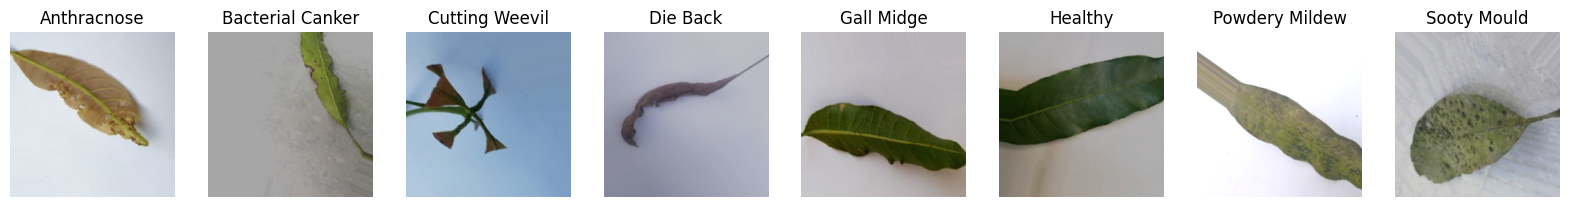

In [ ]:
# Get class names from train_generator
class_names = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))

# To keep track of which classes we've displayed
displayed_classes = set()

# Loop until we have one image per class
while len(displayed_classes) < len(class_names):
    images, labels = next(train_generator)
    for i in range(len(images)):
        label_idx = np.argmax(labels[i])
        if label_idx not in displayed_classes:
            axes[label_idx].imshow(images[i])
            axes[label_idx].set_title(f"{class_names[label_idx]}")
            axes[label_idx].axis('off')
            displayed_classes.add(label_idx)
        if len(displayed_classes) == len(class_names):
            break

plt.show()

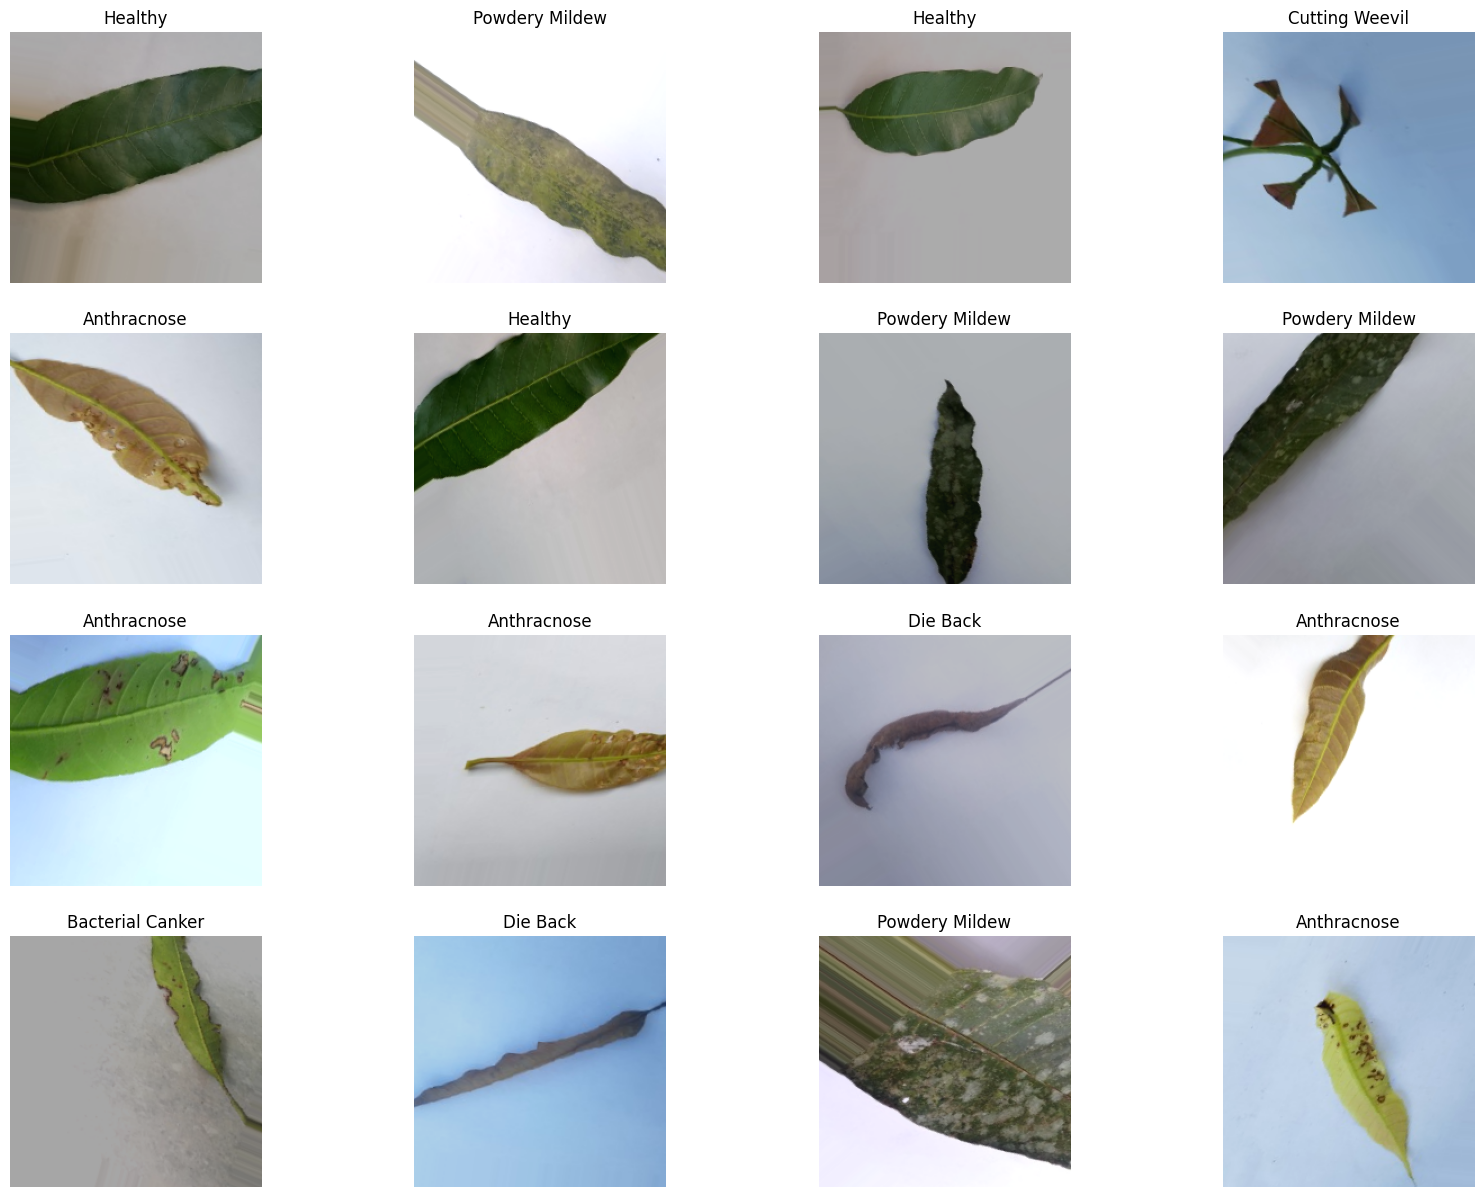

In [ ]:
# Display 16 augmented images from the training set in a 4x4 grid with their class labels
plt.figure(figsize=(20, 15))

for i in range(16):
    if i >= len(images):
        break
    ax = plt.subplot(4, 4, i + 1)  # 4 rows, 4 columns = 16 images
    img = images[i] * 255.0
    plt.imshow(img.astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.show()

In [ ]:
def log_custom_metrics(history, model, generator):
    # Accuracy/Loss plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='train_acc')
    ax[0].plot(history.history['val_accuracy'], label='val_acc')
    ax[0].legend(); ax[0].set_title("Accuracy")

    ax[1].plot(history.history['loss'], label='train_loss')
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].legend(); ax[1].set_title("Loss")

    plt.savefig("training_curves.png")
    mlflow.log_artifact("training_curves.png", artifact_path="plots")
    plt.close(fig)

    # Predictions for Confusion Matrix
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generator.class_indices.keys())
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png", artifact_path="plots")
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=generator.class_indices.keys())
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt", artifact_path="reports")

In [ ]:
from tensorflow.keras.optimizers import AdamW

In [ ]:
#Initialize optimizer with learning rate and weight decay
#optimizer = AdamW(
    #learning_rate=initial_learning_rate,
    #weight_decay=1e-4
#)

# Compile the model
#model.compile(
    #optimizer=optimizer,
    #loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # label smoothing to improve generalization
    #metrics=[
        #'accuracy',
        #tf.keras.metrics.AUC(name='auc'),
        #tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall')
    #]
#)
import tensorflow as tf

# Initialize SGD optimizer with learning rate and momentum
optimizer = tf.keras.optimizers.SGD(
    learning_rate=initial_learning_rate,
    momentum=0.9
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # label smoothing to improve generalization
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

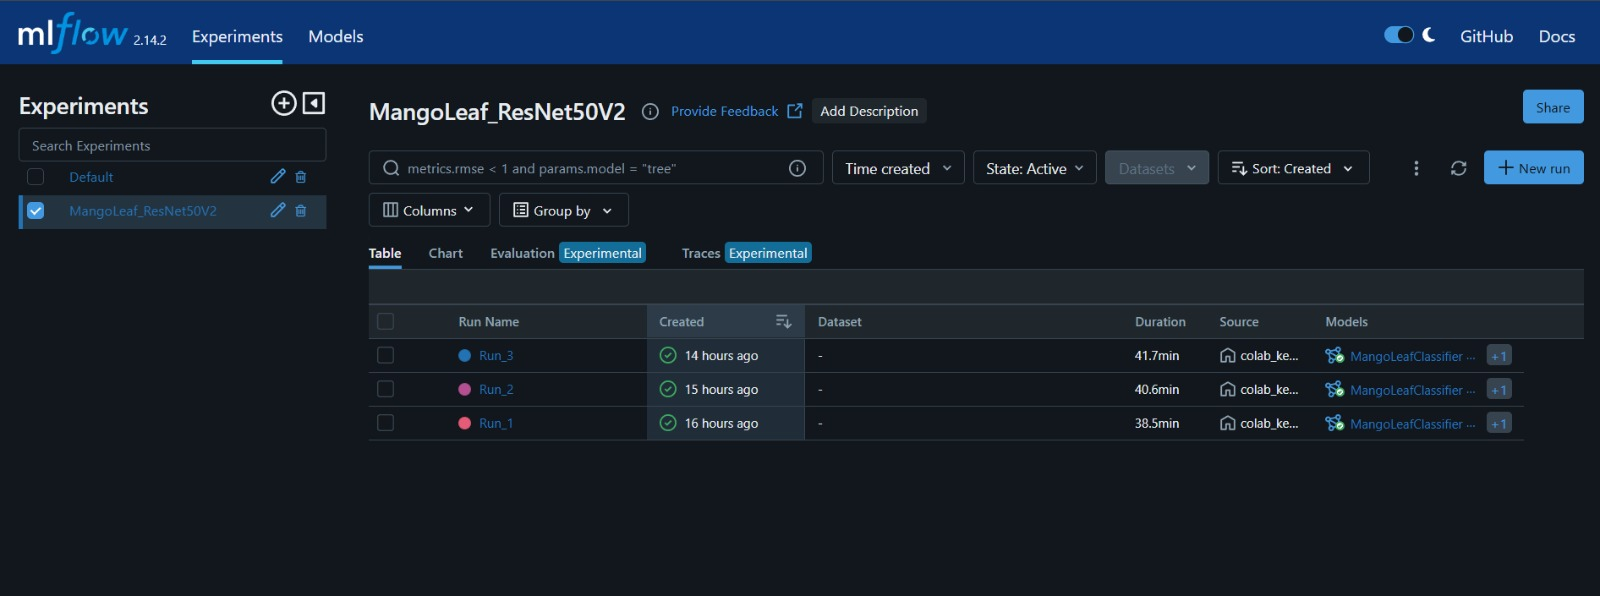

In [ ]:
with start_mlflow_run_auto() as run:
    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )

    # Log hyperparameters

    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Log optimizer details from model
    opt_config = model.optimizer.get_config()
    mlflow.log_param("optimizer", model.optimizer.__class__.__name__)
    for k, v in opt_config.items():
        if isinstance(v, (dict, list)):
            v = str(v)
        mlflow.log_param(f"optimizer_{k}", v)

    # Log learning rate schedule parameters
    mlflow.log_param("initial_learning_rate", initial_learning_rate)
    mlflow.log_param("warmup_epochs", warmup_epochs)
    mlflow.log_param("total_epochs", total_epochs)
    mlflow.log_param("lr_schedule", "warmup_cosine_decay_schedule")

    # Evaluate test set
    test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_generator, verbose=1)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)

    # Log artifacts (plots + metrics)
    log_custom_metrics(history, model, test_generator)

    # Log model & register in MLflow Registry
    try:
        mlflow.keras.log_model(
            model,
            artifact_path="mangoleaf_classifier_model",
            registered_model_name="MangoLeafClassifier"
        )
        print("Model registered successfully in MLflow Model Registry!")
    except MlflowException as e:
        print("Model registration failed:", e)

    print("Run completed with ID:", run.info.run_id)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.2547 - auc: 0.6293 - loss: 3.0443 - precision: 0.2918 - recall: 0.1746
Epoch 1: val_accuracy improved from -inf to 0.79500, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 643ms/step - accuracy: 0.2559 - auc: 0.6305 - loss: 3.0373 - precision: 0.2934 - recall: 0.1755 - val_accuracy: 0.7950 - val_auc: 0.9687 - val_loss: 1.0727 - val_precision: 0.9765 - val_recall: 0.5200 - learning_rate: 2.0000e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5974 - auc: 0.9092 - loss: 1.4466 - precision: 0.7033 - recall: 0.5069
Epoch 2: val_accuracy improved from 0.79500 to 0.87750, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 947ms/step - accuracy: 0.5980 - auc: 0.9094 - loss: 1.4454 - precision: 0.7037 - recall: 0.5075 - val_accuracy: 0.8775 - val_auc: 0.9901 - val_loss: 0.8549 - val_precision: 0.9737 - val_recall: 0.7400 - learning_rate: 4.0000e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7518 - auc: 0.9586 - loss: 1.1491 - precision: 0.8431 - recall: 0.6742
Epoch 3: val_accuracy improved from 0.87750 to 0.90500, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 552ms/step - accuracy: 0.7520 - auc: 0.9586 - loss: 1.1486 - precision: 0.8432 - recall: 0.6743 - val_accuracy: 0.9050 - val_auc: 0.9945 - val_loss: 0.7828 - val_precision: 0.9753 - val_recall: 0.7900 - learning_rate: 6.0000e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8226 - auc: 0.9790 - loss: 0.9736 - precision: 0.8870 - recall: 0.7418
Epoch 4: val_accuracy improved from 0.90500 to 0.94250, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 628ms/step - accuracy: 0.8227 - auc: 0.9790 - loss: 0.9735 - precision: 0.8871 - recall: 0.7418 - val_accuracy: 0.9425 - val_auc: 0.9970 - val_loss: 0.7344 - val_precision: 0.9602 - val_recall: 0.8450 - learning_rate: 8.0000e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8548 - auc: 0.9863 - loss: 0.9010 - precision: 0.9150 - recall: 0.7779
Epoch 5: val_accuracy improved from 0.94250 to 0.94750, saving model to best_mangomodel_0109.keras

Unfreezing layers: 10


100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 604ms/step - accuracy: 0.8548 - auc: 0.9863 - loss: 0.9010 - precision: 0.9150 - recall: 0.7779 - val_accuracy: 0.9475 - val_auc: 0.9972 - val_loss: 0.7188 - val_precision: 0.9697 - val_recall: 0.8800 - learning_rate: 0.0010
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8617 - auc: 0.9881 - loss: 0.8699 - precision: 0.9209 - recall: 0.7805
Epoch 6: val_accuracy improved from 0.94750 to 0.96000, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 656ms/step - accuracy: 0.8618 - auc: 0.9881 - loss: 0.8697 - precision: 0.9209 - recall: 0.7806 - val_accuracy: 0.9600 - val_auc: 0.9981 - val_loss: 0.6857 - val_precision: 0.9810 - val_recall: 0.9050 - learning_rate: 0.0010
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8747 - auc: 0.9884 - loss: 0.8503 - precision: 0.9379 - recall: 0.8006
Epoch 7: val_accuracy did not improve from 0.96000


100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 601ms/step - accuracy: 0.8748 - auc: 0.9884 - loss: 0.8501 - precision: 0.9379 - recall: 0.8006 - val_accuracy: 0.9600 - val_auc: 0.9979 - val_loss: 0.6797 - val_precision: 0.9785 - val_recall: 0.9100 - learning_rate: 9.9799e-04
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8979 - auc: 0.9902 - loss: 0.8056 - precision: 0.9426 - recall: 0.8441
Epoch 8: val_accuracy did not improve from 0.96000


100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 590ms/step - accuracy: 0.8979 - auc: 0.9902 - loss: 0.8056 - precision: 0.9426 - recall: 0.8440 - val_accuracy: 0.9550 - val_auc: 0.9985 - val_loss: 0.6706 - val_precision: 0.9786 - val_recall: 0.9150 - learning_rate: 9.9196e-04
Epoch 9/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9064 - auc: 0.9925 - loss: 0.7831 - precision: 0.9491 - recall: 0.8429
Epoch 9: val_accuracy improved from 0.96000 to 0.97000, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 996ms/step - accuracy: 0.9064 - auc: 0.9925 - loss: 0.7831 - precision: 0.9491 - recall: 0.8429 - val_accuracy: 0.9700 - val_auc: 0.9988 - val_loss: 0.6449 - val_precision: 0.9762 - val_recall: 0.9225 - learning_rate: 9.8198e-04
Epoch 10/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9248 - auc: 0.9958 - loss: 0.7441 - precision: 0.9659 - recall: 0.8667
Epoch 10: val_accuracy did not improve from 0.97000

Unfreezing layers: 20
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 541ms/step - accuracy: 0.9248 - auc: 0.9958 - loss: 0.7441 - precision: 0.9659 - recall: 0.8668 - val_accuracy: 0.9675 - val_auc: 0.9988 - val_loss: 0.6471 - val_precision: 0.9766 - val_recall: 0.9375 - learning_rate: 9.6812e-04
Epoch 11/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9230 - auc: 0.9960 - loss: 0.7362 - precision: 0.9592 - recall: 0.8785
Epoch 11: val_accuracy improved from 0.97000 to 0.97500, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 646ms/step - accuracy: 0.9229 - auc: 0.9960 - loss: 0.7363 - precision: 0.9592 - recall: 0.8784 - val_accuracy: 0.9750 - val_auc: 0.9993 - val_loss: 0.6317 - val_precision: 0.9792 - val_recall: 0.9425 - learning_rate: 9.5048e-04
Epoch 12/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9193 - auc: 0.9955 - loss: 0.7432 - precision: 0.9573 - recall: 0.8633
Epoch 12: val_accuracy did not improve from 0.97500


100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 610ms/step - accuracy: 0.9193 - auc: 0.9955 - loss: 0.7432 - precision: 0.9573 - recall: 0.8633 - val_accuracy: 0.9700 - val_auc: 0.9992 - val_loss: 0.6286 - val_precision: 0.9793 - val_recall: 0.9450 - learning_rate: 9.2922e-04
Epoch 13/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9257 - auc: 0.9961 - loss: 0.7279 - precision: 0.9619 - recall: 0.8742
Epoch 13: val_accuracy improved from 0.97500 to 0.97750, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 572ms/step - accuracy: 0.9257 - auc: 0.9961 - loss: 0.7279 - precision: 0.9619 - recall: 0.8741 - val_accuracy: 0.9775 - val_auc: 0.9994 - val_loss: 0.6159 - val_precision: 0.9820 - val_recall: 0.9525 - learning_rate: 9.0451e-04
Epoch 14/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9249 - auc: 0.9962 - loss: 0.7288 - precision: 0.9598 - recall: 0.8657
Epoch 14: val_accuracy did not improve from 0.97750
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 542ms/step - accuracy: 0.9250 - auc: 0.9962 - loss: 0.7288 - precision: 0.9599 - recall: 0.8658 - val_accuracy: 0.9700 - val_auc: 0.9993 - val_loss: 0.6180 - val_precision: 0.9795 - val_recall: 0.9575 - learning_rate: 8.7654e-04
Epoch 15/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9394 - auc: 0.9972 - loss: 0.7056 - precision: 0.9743 - recall: 0.8846
Epoch 15: val_accuracy improved from 0.97750 to 0.98000, saving model to best_mangomodel_0109.keras

Unfreezing layers: 30


100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.9394 - auc: 0.9972 - loss: 0.7056 - precision: 0.9743 - recall: 0.8846 - val_accuracy: 0.9800 - val_auc: 0.9994 - val_loss: 0.6106 - val_precision: 0.9870 - val_recall: 0.9475 - learning_rate: 8.4553e-04
Epoch 16/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9371 - auc: 0.9967 - loss: 0.7106 - precision: 0.9714 - recall: 0.8849
Epoch 16: val_accuracy did not improve from 0.98000


100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 587ms/step - accuracy: 0.9371 - auc: 0.9967 - loss: 0.7106 - precision: 0.9714 - recall: 0.8849 - val_accuracy: 0.9725 - val_auc: 0.9994 - val_loss: 0.6097 - val_precision: 0.9896 - val_recall: 0.9525 - learning_rate: 8.1174e-04
Epoch 17/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9395 - auc: 0.9967 - loss: 0.7066 - precision: 0.9691 - recall: 0.8888
Epoch 17: val_accuracy did not improve from 0.98000
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 539ms/step - accuracy: 0.9395 - auc: 0.9967 - loss: 0.7066 - precision: 0.9690 - recall: 0.8888 - val_accuracy: 0.9800 - val_auc: 0.9994 - val_loss: 0.6112 - val_precision: 0.9871 - val_recall: 0.9600 - learning_rate: 7.7545e-04
Epoch 18/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9431 - auc: 0.9970 - loss: 0.7007 - precision: 0.9657 - recall: 0.8872
Epoch 18: val_accuracy improved from 0.98000 to 0.98500, saving model to best_mangomodel_0109.keras


100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 651ms/step - accuracy: 0.9431 - auc: 0.9970 - loss: 0.7007 - precision: 0.9657 - recall: 0.8872 - val_accuracy: 0.9850 - val_auc: 0.9991 - val_loss: 0.6034 - val_precision: 0.9871 - val_recall: 0.9600 - learning_rate: 7.3693e-04
Epoch 19/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9385 - auc: 0.9971 - loss: 0.6993 - precision: 0.9665 - recall: 0.8877
Epoch 19: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 547ms/step - accuracy: 0.9384 - auc: 0.9971 - loss: 0.6993 - precision: 0.9665 - recall: 0.8877 - val_accuracy: 0.9800 - val_auc: 0.9995 - val_loss: 0.5998 - val_precision: 0.9896 - val_recall: 0.9525 - learning_rate: 6.9651e-04
Epoch 20/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9440 - auc: 0.9973 - loss: 0.6949 - precision: 0.9699 - recall: 0.8901
Epoch 20: val_accuracy did not improve from 0.98500

Unfreezing layers: 40
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - accuracy: 0.9440 - auc: 0.9973 - loss: 0.6949 - precision: 0.9699 - recall: 0.8902 - val_accuracy: 0.9775 - val_auc: 0.9993 - val_loss: 0.6074 - val_precision: 0.9845 - val_recall: 0.9525 - learning_rate: 6.5451e-04
Epoch 21/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9506 - auc: 0.9982 - loss: 0.6744 - precision: 0.9706 - recall: 0.9026
Epoch 21: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 579ms/step - accuracy: 0.9506 - auc: 0.9982 - loss: 0.6744 - precision: 0.9706 - recall: 0.9026 - val_accuracy: 0.9825 - val_auc: 0.9996 - val_loss: 0.5918 - val_precision: 0.9948 - val_recall: 0.9650 - learning_rate: 6.1126e-04
Epoch 22/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9402 - auc: 0.9973 - loss: 0.6910 - precision: 0.9640 - recall: 0.8905
Epoch 22: val_accuracy did not improve from 0.98500
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 535ms/step - accuracy: 0.9403 - auc: 0.9973 - loss: 0.6909 - precision: 0.9641 - recall: 0.8905 - val_accuracy: 0.9775 - val_auc: 0.9995 - val_loss: 0.5963 - val_precision: 0.9847 - val_recall: 0.9675 - learning_rate: 5.6712e-04
Epoch 23/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9458 - auc: 0.9980 - loss: 0.6845 - precision: 0.9709 - recall: 0.8985
Epoch 23: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 579ms/step - accuracy: 0.9458 - auc: 0.9980 - loss: 0.6845 - precision: 0.9709 - recall: 0.8985 - val_accuracy: 0.9775 - val_auc: 0.9995 - val_loss: 0.5941 - val_precision: 0.9848 - val_recall: 0.9700 - learning_rate: 5.2243e-04
Epoch 24/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9451 - auc: 0.9980 - loss: 0.6793 - precision: 0.9702 - recall: 0.9033
Epoch 24: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 539ms/step - accuracy: 0.9451 - auc: 0.9980 - loss: 0.6793 - precision: 0.9702 - recall: 0.9033 - val_accuracy: 0.9825 - val_auc: 0.9997 - val_loss: 0.5888 - val_precision: 0.9897 - val_recall: 0.9625 - learning_rate: 4.7757e-04
Epoch 25/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9342 - auc: 0.9974 - loss: 0.6899 - precision: 0.9698 - recall: 0.9002
Epoch 25: val_accuracy did not improve from 0.98500

Unfreezing layers: 50
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 527ms/step - accuracy: 0.9343 - auc: 0.9974 - loss: 0.6898 - precision: 0.9699 - recall: 0.9003 - val_accuracy: 0.9775 - val_auc: 0.9995 - val_loss: 0.5956 - val_precision: 0.9821 - val_recall: 0.9575 - learning_rate: 4.3288e-04
Epoch 26/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9579 - auc: 0.9984 - loss: 0.6657 - precision: 0.9760 - recall: 0.9120
Epoch 26: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 590ms/step - accuracy: 0.9579 - auc: 0.9984 - loss: 0.6658 - precision: 0.9761 - recall: 0.9120 - val_accuracy: 0.9825 - val_auc: 0.9996 - val_loss: 0.5890 - val_precision: 0.9872 - val_recall: 0.9675 - learning_rate: 3.8874e-04
Epoch 27/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9548 - auc: 0.9978 - loss: 0.6704 - precision: 0.9814 - recall: 0.9136
Epoch 27: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 594ms/step - accuracy: 0.9547 - auc: 0.9978 - loss: 0.6705 - precision: 0.9813 - recall: 0.9135 - val_accuracy: 0.9825 - val_auc: 0.9997 - val_loss: 0.5860 - val_precision: 0.9898 - val_recall: 0.9700 - learning_rate: 3.4549e-04
Epoch 28/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9572 - auc: 0.9976 - loss: 0.6707 - precision: 0.9803 - recall: 0.9115
Epoch 28: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 574ms/step - accuracy: 0.9571 - auc: 0.9975 - loss: 0.6707 - precision: 0.9803 - recall: 0.9115 - val_accuracy: 0.9850 - val_auc: 0.9995 - val_loss: 0.5857 - val_precision: 0.9897 - val_recall: 0.9600 - learning_rate: 3.0349e-04
Epoch 29/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9478 - auc: 0.9981 - loss: 0.6704 - precision: 0.9746 - recall: 0.9079
Epoch 29: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 615ms/step - accuracy: 0.9478 - auc: 0.9981 - loss: 0.6704 - precision: 0.9746 - recall: 0.9079 - val_accuracy: 0.9825 - val_auc: 0.9995 - val_loss: 0.5841 - val_precision: 0.9898 - val_recall: 0.9675 - learning_rate: 2.6307e-04
Epoch 30/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9470 - auc: 0.9971 - loss: 0.6852 - precision: 0.9653 - recall: 0.9027
Epoch 30: val_accuracy did not improve from 0.98500

Unfreezing layers: 60
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 538ms/step - accuracy: 0.9470 - auc: 0.9971 - loss: 0.6851 - precision: 0.9654 - recall: 0.9028 - val_accuracy: 0.9825 - val_auc: 0.9996 - val_loss: 0.5879 - val_precision: 0.9847 - val_recall: 0.9675 - learning_rate: 2.2455e-04
Epoch 31/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9615 - auc: 0.9986 - loss: 0.6587 - precision: 0.9832 - recall: 0.9122
Epoch 31: val_accuracy did not improve from 0.98500


100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - accuracy: 0.9614 - auc: 0.9986 - loss: 0.6588 - precision: 0.9832 - recall: 0.9122 - val_accuracy: 0.9850 - val_auc: 0.9997 - val_loss: 0.5816 - val_precision: 0.9898 - val_recall: 0.9750 - learning_rate: 1.8826e-04
Epoch 32/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9492 - auc: 0.9980 - loss: 0.6716 - precision: 0.9742 - recall: 0.9037
Epoch 32: val_accuracy did not improve from 0.98500
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.9492 - auc: 0.9980 - loss: 0.6716 - precision: 0.9742 - recall: 0.9037 - val_accuracy: 0.9825 - val_auc: 0.9998 - val_loss: 0.5820 - val_precision: 0.9898 - val_recall: 0.9675 - learning_rate: 1.5447e-04
Epoch 33/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9558 - auc: 0.9979 - loss: 0.6629 - precision: 0.9746 - recall: 0.9178
Epoch 33: val_accuracy did not improve from 0.98500
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.9557 - auc: 0.9979 - loss: 0.6630 

100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9431 - auc: 0.9976 - loss: 0.6767 - precision: 0.9755 - recall: 0.9032 - val_accuracy: 0.9825 - val_auc: 0.9998 - val_loss: 0.5805 - val_precision: 0.9923 - val_recall: 0.9675 - learning_rate: 9.5492e-05
Epoch 35/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9472 - auc: 0.9980 - loss: 0.6688 - precision: 0.9673 - recall: 0.9099
Epoch 35: val_accuracy did not improve from 0.98500

Unfreezing layers: 70
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - accuracy: 0.9472 - auc: 0.9980 - loss: 0.6688 - precision: 0.9673 - recall: 0.9099 - val_accuracy: 0.9850 - val_auc: 0.9998 - val_loss: 0.5806 - val_precision: 0.9949 - val_recall: 0.9675 - learning_rate: 7.0776e-05
Epoch 36/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9598 - auc: 0.9980 - loss: 0.6620 - precision: 0.9761 - recall: 0.9171
Epoch 36: val_accuracy did not improve from 0.98500
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 496ms/step - accuracy: 0.9597 - auc:

100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 515ms/step - accuracy: 0.9532 - auc: 0.9975 - loss: 0.6733 - precision: 0.9733 - recall: 0.9078 - val_accuracy: 0.9850 - val_auc: 0.9997 - val_loss: 0.5796 - val_precision: 0.9949 - val_recall: 0.9700 - learning_rate: 1.8019e-05
Epoch 39/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9474 - auc: 0.9980 - loss: 0.6704 - precision: 0.9734 - recall: 0.9069
Epoch 39: val_accuracy did not improve from 0.98500
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 509ms/step - accuracy: 0.9474 - auc: 0.9980 - loss: 0.6704 - precision: 0.9734 - recall: 0.9069 - val_accuracy: 0.9825 - val_auc: 0.9996 - val_loss: 0.5824 - val_precision: 0.9923 - val_recall: 0.9675 - learning_rate: 8.0352e-06
Epoch 40/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9460 - auc: 0.9969 - loss: 0.6807 - precision: 0.9722 - recall: 0.8955
Epoch 40: val_accuracy did not improve from 0.98500

Unfreezing layers: 80
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 504ms/step - accuracy: 0.9461 - auc:

2025/11/14 20:23:04 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/11/14 20:23:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9829 - auc: 0.9995 - loss: 0.5874 - precision: 0.9826 - recall: 0.9671
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step


2025/11/14 20:23:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
Registered model 'MangoLeafClassifier' already exists. Creating a new version of this model...
2025/11/14 20:23:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MangoLeafClassifier, version 3


Model registered successfully in MLflow Model Registry!
Run completed with ID: 9187cbc3b9754f048cf5dc84dd3ae250


Created version '3' of model 'MangoLeafClassifier'.


In [ ]:
from mlflow.tracking import MlflowClient

def analyze_runs(runs):
    results = []

    for run in runs:
        m = run.data.metrics

        train_acc = m.get("accuracy", 0)
        val_acc   = m.get("val_accuracy", 0)
        val_auc   = m.get("val_auc", 0)

        overfit = train_acc - val_acc
        score = val_acc + val_auc

        results.append({
            "run_id": run.info.run_id,
            "run_name": run.info.run_name,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "val_auc": val_auc,
            "overfit_gap": overfit,
            "score": score
        })
    return results


def pick_best(runs, top_n=3):
    if not runs:
        return []

    # Sort by:
    # 1. smallest overfitting (abs gap)
    # 2. highest performance (score)
    return sorted(runs, key=lambda r: (abs(r["overfit_gap"]), -r["score"]))[:top_n]

# Load experiment runs

client = MlflowClient()
exp_name = "MangoLeaf_ResNet50V2"  # change if needed
exp = mlflow.get_experiment_by_name(exp_name)

all_runs = client.search_runs([exp.experiment_id])

# Process and rank
processed = analyze_runs(all_runs)
top_runs = pick_best(processed)

# Show results
import pandas as pd
pd.DataFrame(top_runs)

run_id run_name  train_acc  val_acc   val_auc  \
0  c6d6f4b1a1b2469281d0c55d3b06a8cb    Run_2   0.983750   0.9975  0.999994   
1  f6ec0aa91abb4660bdc021f3077d19c8    Run_1   0.973437   0.9925  0.999942   
2  9187cbc3b9754f048cf5dc84dd3ae250    Run_3   0.948125   0.9850  0.999594   

   overfit_gap     score  
0    -0.013750  1.997494  
1    -0.019063  1.992442  
2    -0.036875  1.984594

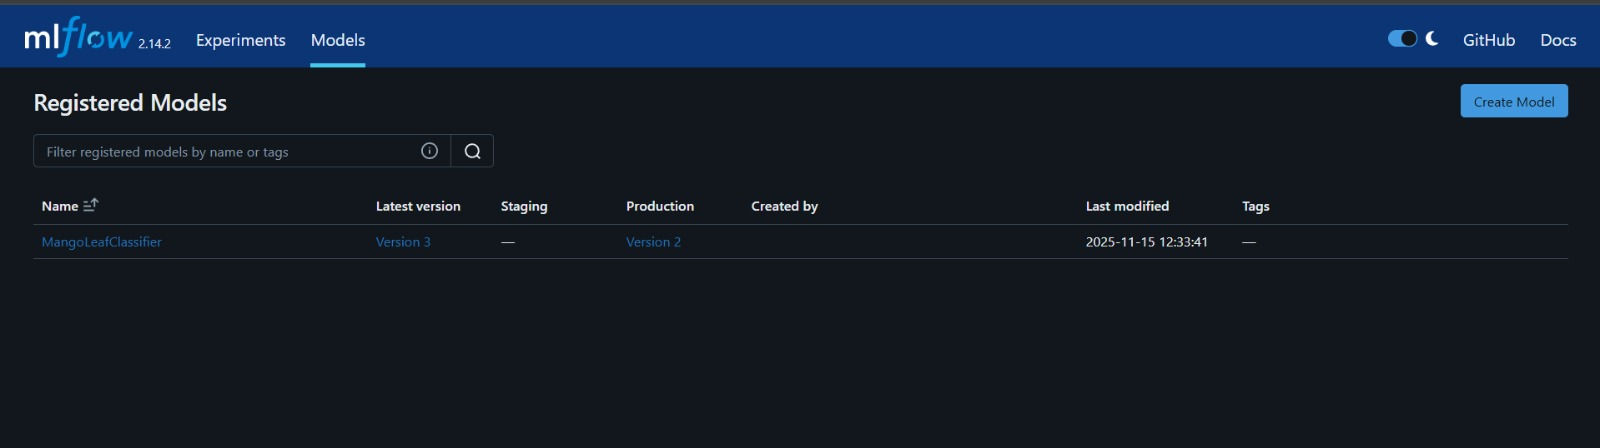

Below plots show that Run 2 performs consistently well, with high accuracy and
low validation loss. This confirms that Run 2 is stable and generalizes well,
which is why it was selected as the best model.

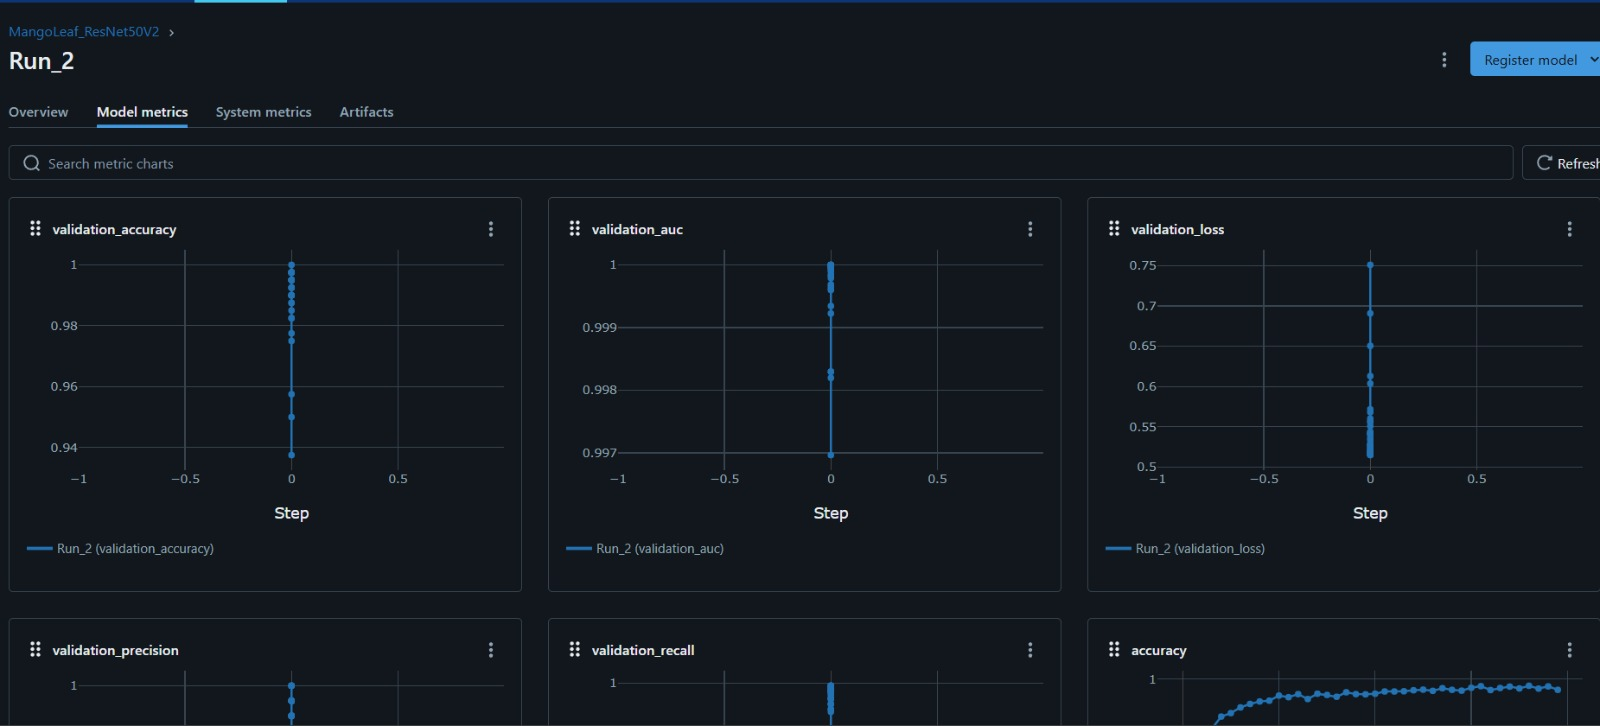

**AUC (Area Under Curve)** shows how well the model can separate the disease
  classes. Higher AUC means better classification performance.
- **Loss** indicates how far the model’s predictions are from the correct labels.
  Lower loss means better learning.
- **Precision** shows how accurate the positive predictions are.

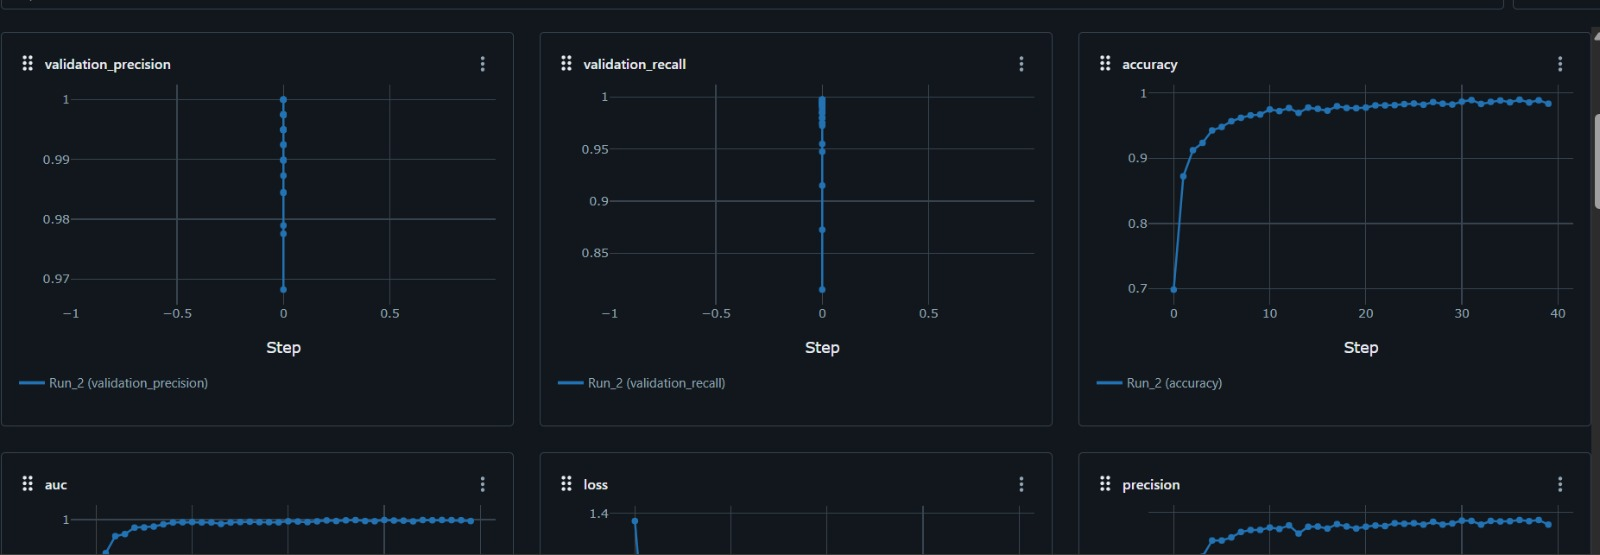

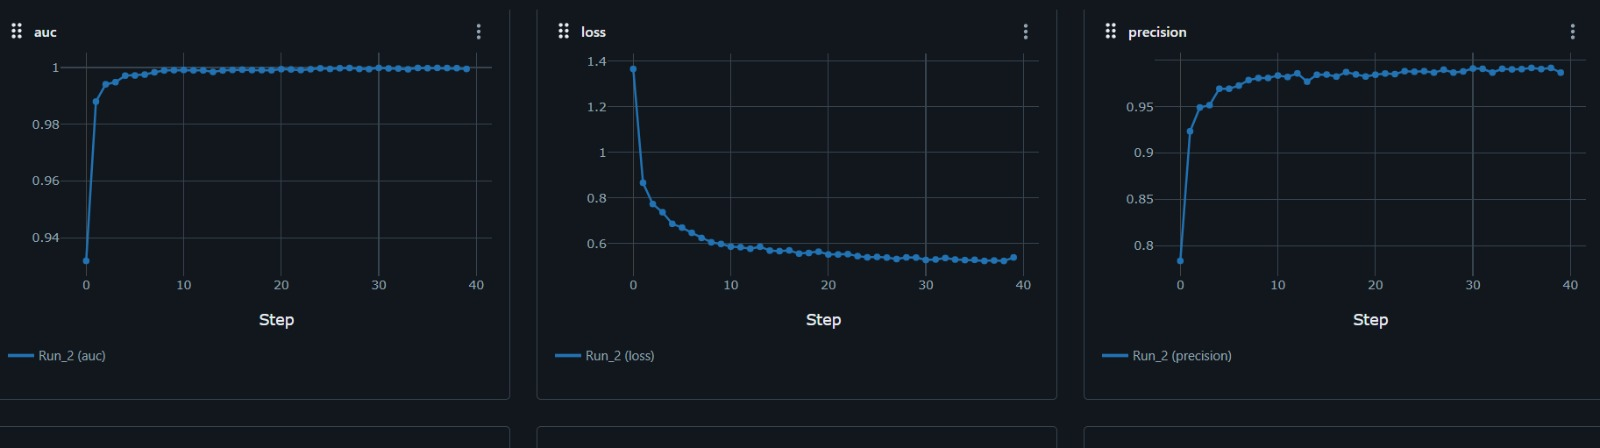

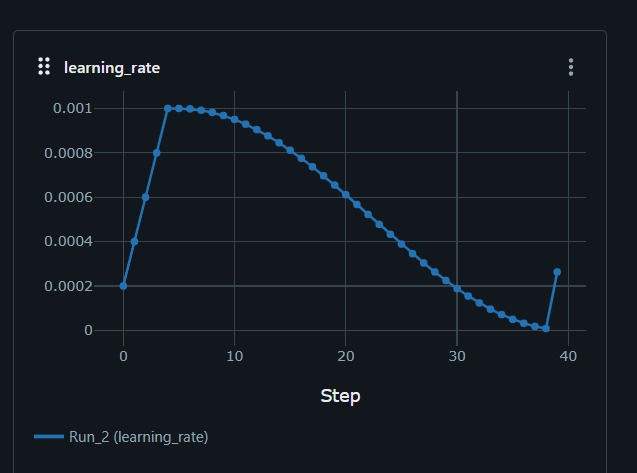

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
models = client.search_model_versions("name='MangoLeafClassifier'")

for m in models:
    print(f"Version: {m.version}, Run ID: {m.run_id}, Stage: {m.current_stage}")

Version: 3, Run ID: 9187cbc3b9754f048cf5dc84dd3ae250, Stage: None
Version: 2, Run ID: c6d6f4b1a1b2469281d0c55d3b06a8cb, Stage: None
Version: 1, Run ID: f6ec0aa91abb4660bdc021f3077d19c8, Stage: None


In [ ]:
client.transition_model_version_stage(
    name="MangoLeafClassifier",
    version=2,   # Run_2’s version
    stage="Production"
)

/tmp/ipython-input-590519999.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1763148744975, current_stage='Production', description='', last_updated_timestamp=1763190221816, name='MangoLeafClassifier', run_id='c6d6f4b1a1b2469281d0c55d3b06a8cb', run_link='', source='/content/drive/MyDrive/mlflow_runs/c6d6f4b1a1b2469281d0c55d3b06a8cb/artifacts/mangoleaf_classifier_model', status='READY', status_message='', tags={}, user_id='', version='2'>

In [ ]:
import mlflow
model = mlflow.pyfunc.load_model("models:/MangoLeafClassifier/Production")

/usr/local/lib/python3.12/dist-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


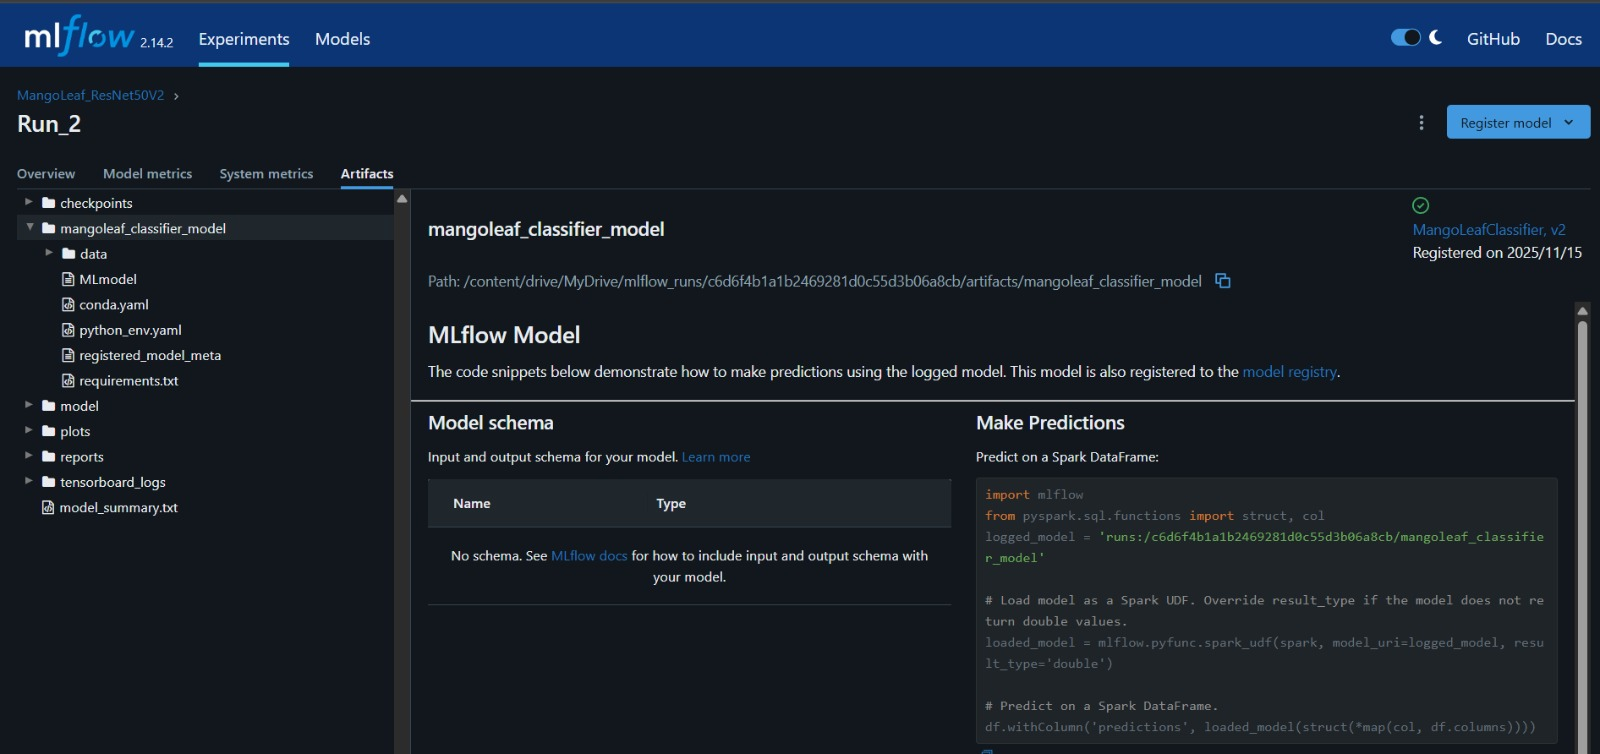

In [24]:
import mlflow
import mlflow.keras

# Your best run info
best_run_id = "c6d6f4b1a1b2469281d0c55d3b06a8cb"  # Run_2
artifact_path = "mangoleaf_classifier_model"       # the artifact path used when logging
save_path = "/content/drive/MyDrive/mango_leaf_model_run2_v2.h5"  # Path to save H5

# Load the Keras model from MLflow
loaded_model = mlflow.keras.load_model(f"runs:/{best_run_id}/{artifact_path}")

# Save as H5
loaded_model.save(save_path)
print(f"Model saved at: {save_path}")

Model saved at: /content/drive/MyDrive/mango_leaf_model_run2_v2.h5
